In [ ]:
# load
from google.colab import drive
drive.mount('MyDrive')
%cd "/content/MyDrive/Shareddrives/Project CompBiomed/data"

Mounted at MyDrive
/content/MyDrive/Shareddrives/Project CompBiomed/data


In [ ]:
!python --version

Python 3.10.12


In [ ]:
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
!pip install wfdb #numpy pandas tqdm seaborn scipy matplotlib scikit-learn Detectors
import wfdb
import glob
import os
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import ast
from scipy.interpolate import interp1d
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import torch.optim as optim
from sklearn.preprocessing import StandardScaler



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.3 MB/s eta 0:00:00


# Data loading

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available()else"cpu")
site_1 = "RVOTSEPTUM"
site_2 = "COMMISURE"
site_3 = "RVOT"
site_4 = "LVOT"

target = site_2

loaded_data = torch.load('data_'+ target+'.pth')

X_train = loaded_data['X_train'].to(device).float()
y_train = loaded_data['y_train'].to(device).float()
patient_train = loaded_data['patient_id_train']

X_test = loaded_data['X_test'].to(device).float()
y_test = loaded_data['y_test'].to(device).float()
patient_test = loaded_data['patient_id_test']

print(f'X_train shape is {X_train.shape}')
print(f'X_test shape is {X_test.shape}')



X_train shape is torch.Size([23200, 12, 200])
X_test shape is torch.Size([5953, 12, 200])


# Model

## Definition of the model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv1d(12, 32, kernel_size=32, stride=1,padding =16)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=32, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=5, stride=2)

        # Each block repeats this pattern, so they need to be declared separately
        self.conv3 = nn.Conv1d(32, 32, kernel_size=32, stride=1, padding='same')
        self.conv4 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv5 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv6 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv7 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv8 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv9 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv10 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32*3, 32)  # Update the input features according to the output of the last MaxPool
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.criterion = nn.BCELoss()

    def forward(self, x):
        x = self.conv1(x)
        identity = x

        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = F.relu(x + identity)
        x = self.pool(x)

        for conv in [self.conv4, self.conv6, self.conv8, self.conv10]:
            identity = x
            x = F.relu(conv(x))
            x = conv(x)
            x = F.relu(x + identity)
            x = self.pool(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x


## Training and evaluation functions

In [ ]:
from sklearn.metrics import confusion_matrix
# Training function
def train_model(model, train_loader, valid_loader, optimizer, epochs=30):
    model = model.to(device)
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for data, labels in train_loader:
            data, labels = data, labels

            optimizer.zero_grad()
            outputs = model(data)

            loss = model.criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)

        average_epoch_loss = epoch_loss / len(train_loader.dataset)
        training_losses.append(average_epoch_loss)

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, labels in valid_loader:
                data, labels = data, labels
                outputs = model(data)

                v_loss = model.criterion(outputs.squeeze(), labels)
                validation_loss += v_loss.item() * data.size(0)

                # Accuracy calculation
                predicted = (outputs.squeeze() >= 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        average_validation_loss = validation_loss / len(valid_loader.dataset)
        validation_accuracy = 100 * correct / total
        validation_losses.append(average_validation_loss)
        print(f'Epoch {epoch+1}: Training Loss: {average_epoch_loss:.4f}, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    return training_losses, validation_losses

# Evaluation function
def evaluate_model_batched(model, dataset, batch_size, device=device):
    model.eval()
    model.to(device)

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, labels in dataset:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predicted = (outputs.squeeze() >= 0.5).float()

            conf_matrix = confusion_matrix(labels.cpu(), predicted.cpu())

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = 100 * total_correct / total_samples
    print(f'Test accuracy: {accuracy:.2f}%')
    return accuracy,conf_matrix


# Training

In [ ]:
epochs = 50
lr = 6e-6
batch_size = 128
seq_length = X_train.shape[2]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert your training and validation data into TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,drop_last=True)


# Create an instance of the model
model = ConvNet()

optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

# Train and evaluate the model
training_loss, validation_loss = train_model(model, train_loader, valid_loader, optimizer, epochs=epochs)


Epoch 1: Training Loss: 0.4091, Validation Loss: 0.3978, Validation Accuracy: 92.76%
Epoch 2: Training Loss: 0.2356, Validation Loss: 0.3386, Validation Accuracy: 92.73%
Epoch 3: Training Loss: 0.1926, Validation Loss: 0.2920, Validation Accuracy: 92.82%
Epoch 4: Training Loss: 0.1656, Validation Loss: 0.2856, Validation Accuracy: 92.83%
Epoch 5: Training Loss: 0.1431, Validation Loss: 0.2631, Validation Accuracy: 92.75%
Epoch 6: Training Loss: 0.1310, Validation Loss: 0.2671, Validation Accuracy: 92.76%
Epoch 7: Training Loss: 0.1167, Validation Loss: 0.2618, Validation Accuracy: 92.73%
Epoch 8: Training Loss: 0.1077, Validation Loss: 0.2592, Validation Accuracy: 92.73%
Epoch 9: Training Loss: 0.1004, Validation Loss: 0.2565, Validation Accuracy: 92.73%
Epoch 10: Training Loss: 0.0956, Validation Loss: 0.2540, Validation Accuracy: 92.75%
Epoch 11: Training Loss: 0.0911, Validation Loss: 0.2664, Validation Accuracy: 92.78%
Epoch 12: Training Loss: 0.0879, Validation Loss: 0.2608, Valid

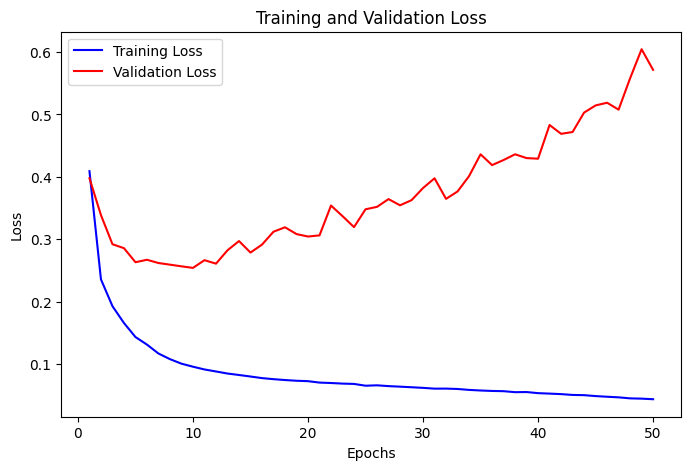

In [ ]:
x = np.arange(1, epochs +1)
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(x, training_loss, label='Training Loss', color='blue')  # Training loss in blue
plt.plot(x, validation_loss, label='Validation Loss', color='red')  # Validation loss in red
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.title('Training and Validation Loss')  # Title of the plot
plt.legend()  # Show legend
plt.show()

Test accuracy: 92.70%


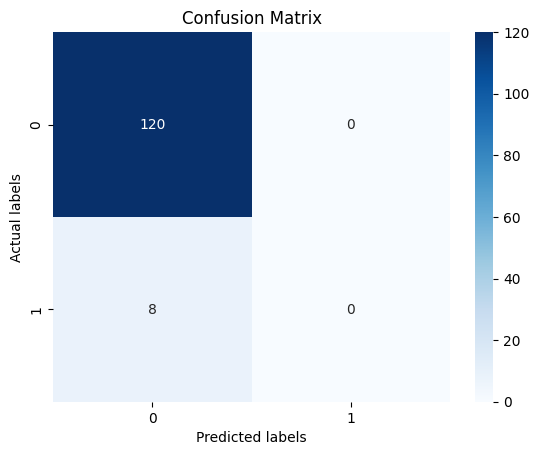

In [ ]:
# evaluate_model(model, X_test, y_test)
import seaborn as sns

acc, conf_matrix = evaluate_model_batched(model, valid_loader, batch_size, device=device)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')

plt.show()

### Saving

In [ ]:
torch.save(model.state_dict(), 'model_v2_'+target+'.pth')


# Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available()else"cpu")
site_1 = "RVOTSEPTUM"
site_2 = "COMMISURE"
site_3 = "RVOT"
site_4 = "LVOT"

target = site_4

loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load('model_' + target + '.pth'))


<All keys matched successfully>

In [ ]:
loaded_data = torch.load('data_'+ target+'.pth')

X_train = loaded_data['X_train'].to(device).float()
y_train = loaded_data['y_train'].to(device).float()
patient_train = loaded_data['patient_id_train']

X_test = loaded_data['X_test'].to(device).float()
y_test = loaded_data['y_test'].to(device).float()
patient_test = loaded_data['patient_id_test']

batch_size = 128

# Convert your training and validation data into TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,drop_last=True)


Test accuracy: 85.21%


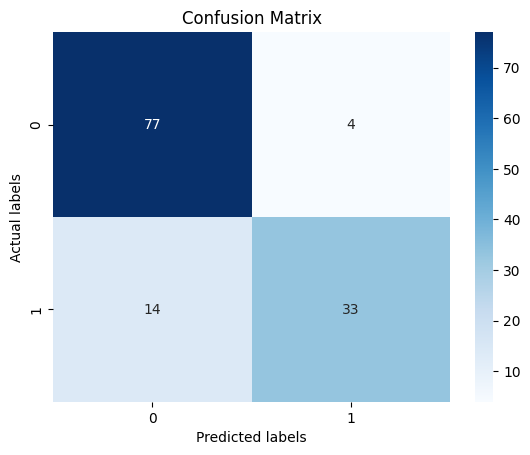

In [ ]:
# evaluate_model(model, X_test, y_test)
import seaborn as sns

acc, conf_matrix = evaluate_model_batched(loaded_model, valid_loader, batch_size, device=device)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')

plt.show()